In [19]:
# %%writefile Ind_xxxxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat


In [ ]:
# Amihud定义了ILLIQ度量
# 一个粗略而实用的价格影响指标考虑了一段时间内绝对股票收益率与美元成交量的日平均比率。遵循Kyle的流动性概念，
# ILLIQ = 1/n * sum_t(|r_t|/v_t)

In [ ]:
# 均衡度量
# 基于均衡价格的测度试图捕捉向均衡价格的有序移动，主要是为了衡量弹性
# 市场效率系数（MEC）用于衡量价格变动的连续性：
# MEC = Var(R_t) / N*Var(r_t)

# Var（Rt）是对数长周期收益的方差，Var（Rt）是对数短周期收益的方差，N是每个长周期内的短周期数。

# 在更具弹性的市场中，这一比率往往接近但略低于1。低市场弹性意味着过度的短期波动，而价格四舍五入、利差和不准确的价格发现等因素将推动MEC远低于1。
# 做市商干预和价格决定不准确后对新信息的部分调整等因素将抑制短期波动，导致MEC升至1以上。

In [ ]:
# 市场调整度量
# 市场调整措施试图区分流动性引起的价格变动和一般市场状况或新信息到达等因素引起的价格变动。当新的信息可用时，即使是小的交易量也可能与大的价格变动相关联。

# 在股票市场上，经常根据资本资产定价模型（CAPM）区分系统性风险和非系统性风险，CAPM也提供了一种提取市场波动的方法。
# 系统性风险不能分散，因为它影响到所有证券。系统风险的程度称为股票的β，它是指股票的日收益率Ri与市场Rm的日收益率Ri的回归系数：
# Ri= α + β*R_m+ui

# 然后，使用回归残差ui将其方差与交易额的每日百分比变化联系起来

# ui^2 = γi + γ2*ΔVi+ ei
# 经市场调整的流动性利用资产回报率与市场回报率之间的回归残差（从而将其从系统风险中清除）来确定资产的内在流动性。
# γ2越小，交易量对资产价格波动性的影响越小，这意味着资产是流动的。系数越低，市场的宽度就越大。

# 没有一个单一的衡量标准明确地衡量紧密性、即时性、深度、广度和弹性。
# 然而，从从业者的角度来看，基于交易难度的证券聚类是可能的，这取决于许多因素，但主要取决于波动性、盘口价差、价格、排队规模、成交量等。



In [21]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = True
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2022'
year2 = '2022'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()


# ret = smpl.get_forward_return(data_,'close')
# ret.name = 'ret_forward'
# ret[np.abs(ret)>0.15]=np.nan

In [15]:
from base.JuUnits import excute_for_multidates

# x = excute_for_multidates(data_, lambda x:x.shape[0],level='code')

def excute_priod_limit(stocks_df, limit=60):
    '''排除数据（交易天数or时间）过少的数据
    :param stocks_df: {pd.DataFrame 或 stock_struct}
    :param limit: {int} --数据量（天数）限制
    :return: {pd.DataFrame} --返回原数据对象的指针，未新建对象
    '''
    count = excute_for_multidates(stocks_df, lambda x:x.shape[0],level='code')
    exclude = count[x<=limit]
    if exclude.count() == 0:
        return stocks_df
    excluded_codes = stocks_df.index.get_level_values('code').difference(exclude.index)
    return stocks_df.loc[(slice(None),exclude_new),]

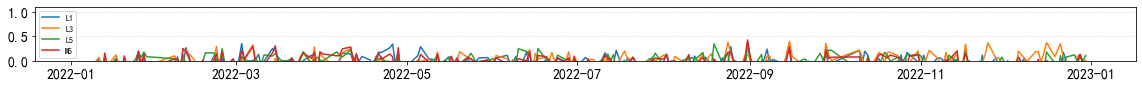

In [54]:
# x = smpl.get_current_return(data_,'close')

ranks = x.groupby([x.index.get_level_values(0)]).rank()
asset_rank = ranks.reset_index().pivot(index='date',columns='code')
autocorr1 = asset_rank.corrwith(asset_rank.shift(1), axis=1)
autocorr3 = asset_rank.corrwith(asset_rank.shift(3), axis=1)
autocorr5 = asset_rank.corrwith(asset_rank.shift(5), axis=1)
autocorrma5 = asset_rank.corrwith(asset_rank.shift(1).rolling(5).mean(), axis=1)
fig = plt.figure(figsize=(1420/72,500/72/7))
ax = fig.gca()
ax.set_ylim(0,1.1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.plot(autocorr1.index.get_level_values(0).unique().tolist(),autocorr1.values.tolist(),label='L1')
ax.plot(autocorr3.index.get_level_values(0).unique().tolist(),autocorr3.values.tolist(),label='L3')
ax.plot(autocorr5.index.get_level_values(0).unique().tolist(),autocorr5.values.tolist(),label='L5')
ax.plot(autocorrma5.index.get_level_values(0).unique().tolist(),autocorrma5.values.tolist(),label='M5')
ax.yaxis.grid(linestyle="dotted",color="lightgray")
plt.legend(loc='upper left',fontsize='xx-small')
plt.show()
